# Start of training
this logs info about the runtime then downloads the kaggle datset using my kaggle key.

**THIS MUST BE DONE EACH TIME THE RUNTIME IS STARTED OVER.**
It is tedious but the images must be in the runtime memory to be fast enough.

i am storing my runs in the document **DAT255 notes > DAT255 RUNS**. Here i write what changes i am doing, often why and what the results were.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers, preprocessing
from tensorflow.keras.utils import to_categorical

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

!mkdir -p ~/.kaggle
!echo '{"username":"vegardaaalbretsen","key":"18f385007d1223dd35dc94f16e311545"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
#!kaggle datasets download -d puneet6060/intel-image-classification
#!unzip intel-image-classification.zip -d /content/dataset

#!kaggle datasets download -d seryouxblaster764/fgvc-aircraft
#!unzip fgvc-aircraft.zip -d /content/dataset



Mon Apr 21 09:03:05 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!kaggle datasets download -d tusonggao/imagenet-train-subset-100k --unzip

Dataset URL: https://www.kaggle.com/datasets/tusonggao/imagenet-train-subset-100k
License(s): unknown
^C


## What am i typically changing?
first and foremost learning rate with different schedulers and epochs.
after that there has been a lot of fiddling with augmentation, image resolution (which then often pushes the ram requirements). Higher resolution often requires smaller model, smaller batch size and such.


### What would I do?
I would maybe try to find some architecture (like densenet or something) and try to alter my model a bit. I feel like this architecture with this size wont get that much better than 60%.

You could also increase depth and reduce width (base amount of filters) or the opposite. I have an idea that more depth (to capture more advanced features) might be beneficial.

## Image preprocessing
Here you have image resolution, batch size and augmentation.
The problem with augmentation (and dropout/regularization) is that the line between too little and too much is tight.

### HOW TO KNOW WHEN TO INCREASE/DECREASE AUGMENTATION/REGULARIZATION
Overfitting = Accuracy >> validation accuracy ==> **YOU CAN INCREASE A BIT**
Not learning = Accuracy == Validation accuracy == 0.01 ==> **DECREASE AUGMENTATION/REGULARIZATION**

Remember to monitor this DURING the run, because suddenly you have ran for 2 hrs and it still is 0.01 accuracy.

I feel like the the line between these two are difficult, and i have either accuracy 20 percentage-points above val accuracy at the end, or it is not learning.

In [ ]:
!pip install torch torchvision


In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers, preprocessing
from tensorflow.keras.utils import to_categorical

# Define the path to the dataset
dataset_path = '/content/dataset'
image_path = '/content/dataset/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images'

# Load CSV files
train_df = pd.read_csv(os.path.join(dataset_path, 'train.csv'))
val_df = pd.read_csv(os.path.join(dataset_path, 'val.csv'))
test_df = pd.read_csv(os.path.join(dataset_path, 'test.csv'))

# Add full image paths to DataFrames
train_df['filepath'] = train_df['filename'].apply(lambda x: os.path.join(image_path, x))
val_df['filepath'] = val_df['filename'].apply(lambda x: os.path.join(image_path, x))
test_df['filepath'] = test_df['filename'].apply(lambda x: os.path.join(image_path, x))

# Convert class labels to categorical
train_df['Labels'] = train_df['Labels'].astype(str)
val_df['Labels'] = val_df['Labels'].astype(str)
test_df['Labels'] = test_df['Labels'].astype(str)

# Image and Batch size
img_size = (370,540)
batch_size = 24

# THIS IS TOO MUCH
# can experiment with https://keras.io/api/layers/preprocessing_layers/
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),  # Reduced rotation factor
    layers.RandomZoom(0.1),  # Reduced zoom factor
    layers.RandomTranslation(0.05, 0.05),  # Reduced translation factor
    layers.RandomContrast(0.1),  # Reduced contrast factor
    layers.RandomBrightness(0.1),  # Reduced brightness factor
    layers.RandomCrop(360, 520),  # Slightly larger crop size to reduce cropping effect
])

def load_and_augment_image1(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = img[:-12, :, :]  # Remove the black line on the bottom
    img = tf.image.resize(img, img_size) / 255.0  # Normalize
    label = tf.reshape(label, [])

    img = data_augmentation(img)  # Apply data augmentation
    img = tf.image.resize(img, img_size)  # Resize Back

    return img, label

# Function to load and preprocess images with augmentation for training
def load_and_augment_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = img[:-12, :, :]  #Remove the black line on the bottom
    img = tf.image.resize(img, img_size) / 255.0  # Normalize
    label = tf.reshape(label, [])

    # Apply Data Augmentation
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.2)
    img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
    img = tf.image.random_saturation(img, lower=0.85, upper=1.1)
    img = tf.image.random_hue(img, max_delta=0.0125)


    # **Additional Transformations**
    img = tf.image.random_crop(img, size=[350, 500, 3])  # ✅ Random Cropping (optional)
    img = tf.image.resize(img, img_size)  # Resize Back

    return img, label

# Function to load images without augmentation for validation/testing
def load_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = img[:-12, :, :]  # Remove the black line on the bottom
    img = tf.image.resize(img, img_size) / 255.0  # Normalize
    label = tf.reshape(label, [])
    return img, label

# Convert DataFrames to TensorFlow datasets
def dataframe_to_dataset(df, batch_size=batch_size, shuffle=True, augment=False):
    file_paths = df['filepath'].values
    labels = df['Labels'].astype('category').cat.codes.values  # Convert labels to numerical format
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))

    if augment:
        dataset = dataset.map(lambda x, y: load_and_augment_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    else:
        dataset = dataset.map(lambda x, y: load_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(len(df))
    dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(2)  # Ensure consistency
    return dataset

# Create datasets using tf.data pipeline with augmentation for training
train_airplane = dataframe_to_dataset(train_df, batch_size=batch_size, augment=True)
val_airplane = dataframe_to_dataset(val_df, batch_size=batch_size, shuffle=False, augment=False)
test_airplane = dataframe_to_dataset(test_df, batch_size=batch_size, shuffle=False, augment=False)

## Once used to log the distribution of resolutions
not necessary

Minimum Resolution: 775x413
Maximum Resolution: 1600x1205


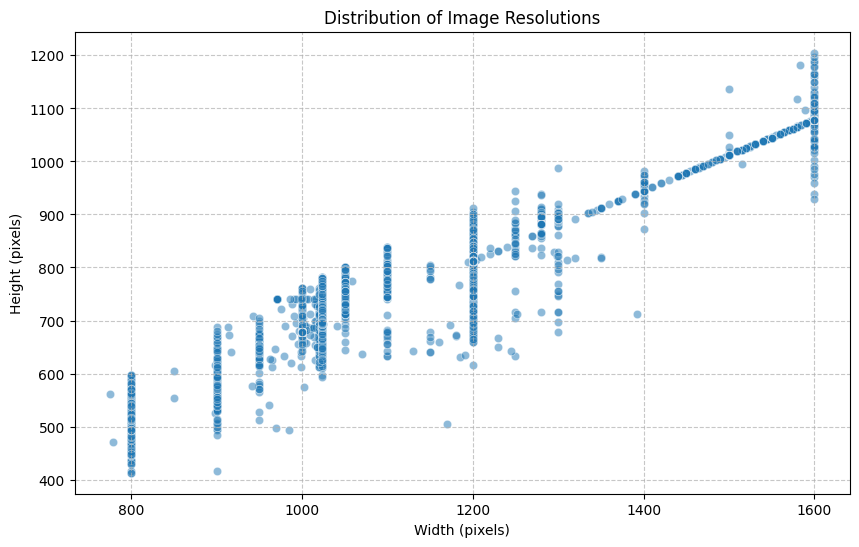

In [ ]:
import os
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

# Define the path to the dataset
image_path = '/content/dataset/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images'

# Initialize a list to store image dimensions
image_dimensions = []

# Iterate through each image file in the dataset
for filename in os.listdir(image_path):
    if filename.endswith('.jpg'):  # Ensure the file is an image
        with Image.open(os.path.join(image_path, filename)) as img:
            width, height = img.size
            image_dimensions.append((width, height))

# Convert the list to a DataFrame for analysis
df = pd.DataFrame(image_dimensions, columns=['Width', 'Height'])

# Calculate minimum and maximum resolutions
min_resolution = df.min()
max_resolution = df.max()

print(f"Minimum Resolution: {min_resolution['Width']}x{min_resolution['Height']}")
print(f"Maximum Resolution: {max_resolution['Width']}x{max_resolution['Height']}")

# Plot the distribution of image resolutions
plt.figure(figsize=(10, 6))
plt.scatter(df['Width'], df['Height'], alpha=0.5, edgecolors='w', linewidth=0.5)
plt.title('Distribution of Image Resolutions')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()



## Relu6 activation function
Not currently in use, swap all activation layers that currently are layers.Activation(tf.nn.silu) for layers.Activation("relu6") to use.

In [ ]:
def relu6(x):
    return tf.nn.relu6(x)

## Squeeze and exitation module
This is a part of the more recent mobilenet architectures, V2 or V3 i think.

The SE block, however, introduces an adaptive approach where the importance of each channel is individually assessed based on its context. In simpler terms, the SE block takes into account the relevance of each channel when computing the output.

https://medium.com/@tahasamavati/squeeze-and-excitation-explained-387b5981f249

In [ ]:
def se_module(inputs, reduction=4):
    input_channels = inputs.shape[-1]
    reduced_channels = input_channels // reduction

    se = layers.GlobalAveragePooling2D()(inputs)
    se = layers.Reshape((1, 1, input_channels))(se)
    se = layers.Dense(reduced_channels, activation='relu')(se)
    se = layers.Dense(input_channels, activation='sigmoid')(se)
    return layers.multiply([inputs, se])

## Stochastic depth layer
Has a probability *p* to be dropped, but only during training.  
This is supposed to prevent the model from relying too much on any one feature

In [ ]:
@tf.keras.utils.register_keras_serializable()
class StochasticDepth(tf.keras.layers.Layer):
    def __init__(self, drop_prob=0.2, **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = drop_prob

    def call(self, inputs, training=None):
        if training:
            keep_prob = 1.0 - self.drop_prob
            batch_size = tf.shape(inputs)[0]
            random_tensor = keep_prob + tf.random.uniform([batch_size, 1, 1, 1], dtype=inputs.dtype)
            binary_tensor = tf.floor(random_tensor)  # Convert to 0 or 1
            return inputs * binary_tensor / keep_prob  # Scale for variance correction
        return inputs


## Standard MobileNetV2 Inverted Residual block
With an added stochastic-depth block


In [ ]:
def inverted_residual_block(inputs, expansion_factor, output_channels, stride, use_se=True, dropout_rate=0.175, drop_prob=0.2, dilation_rate=1):
    input_channels = inputs.shape[-1]
    expanded_channels = input_channels * expansion_factor

    # Expansion Phase
    x = layers.Conv2D(expanded_channels, kernel_size=1, padding='same', use_bias=False)(inputs)
    x = layers.Activation(tf.nn.silu)(x)
    x = layers.BatchNormalization()(x)

    # Depthwise Convolution
    x = layers.DepthwiseConv2D(kernel_size=3, strides=stride, padding='same', dilation_rate=dilation_rate, use_bias=False)(x)
    x = layers.Activation(tf.nn.silu)(x)
    x = layers.BatchNormalization()(x)

    # Squeeze-and-Excitation Module (Optional)
    if use_se:
        x = se_module(x)

    # Dropout to reduce overfitting
    x = layers.Dropout(dropout_rate)(x)

    # Projection Phase
    x = layers.Conv2D(output_channels, kernel_size=1, padding='same', use_bias=False, kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)

    # ✅ Apply Stochastic Depth before residual connection
    x = StochasticDepth(drop_prob=drop_prob)(x)


    # Residual Connection
    if stride == 1 and input_channels == output_channels:
        x = layers.add([inputs, x])

    return x


## Regular residual block with stochastic depth
This is not in use. I used this to compare the two.


In [ ]:
from tensorflow.keras import layers

def residual_block(inputs, output_channels, stride=1, use_se=True, dropout_rate=0.15, drop_prob=0.2):
    input_channels = inputs.shape[-1]

    # First Convolution
    x = layers.Conv2D(output_channels, kernel_size=3, strides=stride, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Second Convolution
    x = layers.Conv2D(output_channels, kernel_size=3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # Squeeze-and-Excitation Module (Optional)
    if use_se:
        x = se_module(x)

    # Dropout to reduce overfitting
    x = layers.Dropout(dropout_rate)(x)

    # Apply Stochastic Depth before residual connection
    x = StochasticDepth(drop_prob=drop_prob)(x)

    # Residual Connection
    if stride == 1 and input_channels == output_channels:
        x = layers.add([inputs, x])

    return x


## Efficientnet scaling
We use a compound scaling coefficient (ϕ) to scale:

- Depth (number of blocks)
- Width (number of filters)
- Resolution (input image size)

This should scale the model dynamically in an EfficientNet- manner

This is kinda pointless, since the model gets too big too fast if i use anything other than 0

In [ ]:
def scale_parameters(base_depth, base_width, phi, alpha=1.2, beta=1.1, gamma=1.15):
    depth = int(base_depth * alpha ** phi)
    width = int(base_width * beta ** phi)
    return depth, width


## Building the model
This is set up in a dynamiaclly scaling way

Here we can change the ratio of base depth and width. Remember that we can also scale the model when using the build_scaled_model function but if the depth and width stay the same, the shape of the model will be the same, if that makes sense

In [ ]:
from tensorflow.keras.regularizers import l2

def build_scaled_model(phi, input_shape=(370,540, 3), num_classes=100):
    base_depth = 4   # Number of IR blocks per stage
    base_width = 112  # Initial number of filters

    depth, width = scale_parameters(base_depth, base_width, phi)

    inputs = layers.Input(shape=(370,540,3))

    # Initial Conv Layer
    x = layers.Conv2D(width, kernel_size=3, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.Activation(tf.nn.silu)(x)
    x = layers.BatchNormalization()(x)

    # Stacking Inverted Residual Blocks with Scaling & Stochastic Depth
    for i in range(depth):
        stride = 1 if i > 0 else 2  # Stride 2 for first block in each stage
        drop_prob = min(0.05 + (0.02 * i), 0.2)
        dilation_rate = 2 if i == depth - 1 else 1  # Increase dilation rate for the last block
        x = inverted_residual_block(x,
                                    expansion_factor=4,
                                    output_channels=width,
                                    stride=stride,
                                    use_se=True,
                                    drop_prob=drop_prob,
                                    dilation_rate=dilation_rate)
        width *= 2  # Increase filters at each stage

    # Final Global Pooling and Classifier
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, x)
    return model


## Building the model
Now we can build different size models by adjusting the phi


---


Under i am doing a summary of the model. This is used to assess how big of a difference the change i made had.


In [ ]:
small_model = build_scaled_model(phi=0)  # Small
#medium_model = build_scaled_model(phi=1) # medium


In [ ]:
small_model.summary()
print(len(small_model.layers))
#medium_model.summary()
#large_model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 370, 540, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 185, 270, 112)  │          3,024 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_9 (Activation) │ (None, 185, 270, 112)  │              0 │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_13    │ (None, 185, 270, 112)  │            448 │ activation_9[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 185, 270, 448)  │         50,176 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_10             │ (None, 185, 270, 448)  │              0 │ conv2d_10[0][0]        │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_14    │ (None, 185, 270, 448)  │          1,792 │ activation_10[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ depthwise_conv2d_4        │ (None, 93, 135, 448)   │          4,032 │ batch_normalization_1… │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_11             │ (None, 93, 135, 448)   │              0 │ depthwise_conv2d_4[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_15    │ (None, 93, 135, 448)   │          1,792 │ activation_11[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 448)            │              0 │ batch_normalization_1… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_4 (Reshape)       │ (None, 1, 1, 448)      │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 1, 1, 112)      │         50,288 │ reshape_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 1, 1, 448)      │         50,624 │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_4 (Multiply)     │ (None, 93, 135, 448)   │              0 │ batch_normalization_1… │
│                           │                        │                │ dense_10[0][0]         │
├──────────────────────

 Total params: 5,634,484 (21.49 MB)

 Trainable params: 5,616,564 (21.43 MB)

 Non-trainable params: 17,920 (70.00 KB)

66


### Cosine Annealing scheduler like efficientnet
This is a learning rate scheduler that reduces the learning rate gradually over time instead of dropping it suddenly.
probably good.

In [ ]:
def cosine_annealing(epoch, lr):
    min_lr = 1e-7  # Raise this a bit (previously 1e-6)
    max_lr = 4.5e-4  # Slightly higher than before
    T_max = 150  # Stretch over 200 epochs for slower decay

    new_lr = min_lr + (max_lr - min_lr) * (1 + tf.math.cos(epoch / T_max * 3.141592653589793)) / 2
    return float(new_lr)


## 1Cycle learning rate scheduling
i gathered this from the pensumbok and it has worked well.
Doesnt work with early stopping since it works its way up in LR then back down.

In [ ]:
from tensorflow.keras.optimizers import Nadam

total_epochs = 150
initial_lr = 4.5e-4
max_lr = 4.5e-3
min_lr = 1e-7

optimizer = Nadam(learning_rate=initial_lr, clipnorm=1.0)

# Implement the 1cycle learning rate policy
def lr_schedule(epoch, lr):
    if epoch < total_epochs * 0.33:  # Ramp-up (0-33%)
        lr = initial_lr + (max_lr - initial_lr) * (epoch / (total_epochs * 0.33))
    elif epoch < total_epochs * 0.8:  # Ramp-down (33-80%)
        lr = max_lr - (max_lr - initial_lr) * ((epoch - total_epochs * 0.33) / (total_epochs * 0.47))
    else:  # Final decay (80-100%)
        lr = initial_lr - (initial_lr - min_lr) * ((epoch - total_epochs * 0.8) / (total_epochs * 0.2))
        lr = max(lr, min_lr)  # Ensure lr does not go below min_lr
    return lr

# Callbacks
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)


Initialization of the cosine annealing scheduler, early stopping and reduceLROnPlateau. These have the option to "start_from_epoch" so that they can be used together with a scheduler like 1cycle, allthough reduceLROnPlateau wont be necessary with another lr scheduler as its already handling the lr.

Can also be set to monitor accuracy, but then also "mode='max'" since that is a maximation problem.

In [ ]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(cosine_annealing, verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=15, restore_best_weights=True, start_from_epoch=50, mode='min'
)
#Reduces Learning rate on plateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=5, min_lr=1e-7, start_from_epoch=50, mode='min'
)


### Manual scheduler
Made a manual scheduler because i thought i was smart.
I wasnt.

In [ ]:
def manual_lr_schedule(epoch, lr):
    if epoch > 100:
        lr = 2e-3
    elif epoch > 80:
        lr = 2.5e-3
    elif epoch > 60:
        lr = 3e-3
    elif epoch > 40:
        lr = 3.5e-3
    elif epoch > 20:
        lr = 4e-3
    return lr


#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(manual_lr_schedule)

### Gradual warmup scheduler
Used to check the "optimal learning rate" for a model. you can run this and see when it takes a turn for the worse in loss and accuracy and that will be the optimal learning rate.
Idea is taken from the pensumbok

In [ ]:
import tensorflow as tf
import numpy as np

def gradual_warmup_scheduler(epoch, start_lr=1e-6, end_lr=1e-3, num_epochs=40):
    """Linearly increases learning rate from start_lr to end_lr over num_epochs."""
    lrs = np.linspace(start_lr, end_lr, num=num_epochs)
    return lrs[min(epoch, num_epochs - 1)]  # Ensure it doesn't go beyond num_epochs

# Create a callback for model.fit()
lr_warmscheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: gradual_warmup_scheduler(epoch, 1e-7, 1e-2, 40), verbose=1)


## Initialize and compile
Initializing to my weights and biases account with the key: "16894d54870c080a5b32b6c1fe211f8a09a38545"
This will save the intermediate results to a graph in weights and biases.

Also need to do Wandb.finish() after to stop this run, otherwise it will just keep going at "epoch 0" on the same run.

In [ ]:
# Automatically logs training metrics and hyperparameters
#!pip install wandb
import wandb
from wandb.integration.keras import WandbCallback
from tensorflow.keras.optimizers import Nadam

wandb.init(project="Airplane-track")
wandb_callback = WandbCallback(save_graph=False, save_model=False)
print(wandb.run.name)
optimizer = Nadam(learning_rate=4.5e-3, clipnorm=1.0)
#Compile the model
small_model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy",
             #"precision",
             #"recall"
             ],
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: 599002 (599002-h-gskulen-p-vestlandet) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: WARNING WandbCallback is deprecated and will be removed in a future release. Please use the WandbMetricsLogger, WandbModelCheckpoint, and WandbEvalCallback callbacks instead. See https://docs.wandb.ai/guides/integrations/keras for more information.


trim-disco-82


Extra compiler in case i do not need to run all the code over again.

In [ ]:
small_model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy",
             #"precision",
             #"recall"
             ],
)

This saves the model to the runtime memory. This means that when we do 'wandb.save(wandb.run.name + "keras") later, it uploads the best model to wandb storage that can be gathered later

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    wandb.run.name + ".keras",
    monitor='val_accuracy',  # monitor validation loss or any desired metric
    verbose=1,
    save_best_only=True,
    mode='max'  # 'min' for metrics like loss, 'max' for accuracy
)

# Training and logging
This trains the model, plots the results, logs them to wandb, evaluates the model on the test data and finishes the run.

## Normal errors
### ResourceExhaustionError
Self-explainatory. Lower Batch-size, number of base filters, number of base depth, simplify in some way.
### Shape mismatch / tensor mismatch
I have gotten this when adding new layers and when changing number of filters. The model passes the output channel number dynamically so that should be fine. When i have changed the number of filters, sometimes i have probably inserted an uncompatible number. just try to make it an even number and it is probably fine.
### NotImplementedError: numpy() is only available when eager execution is enabled
Usually happens when the .fit() crashes and you try to run it again. I think it then reinitializes with an old tensorflow version or something?
You can either:


*   run the code: "tf.keras.backend.clear_session()"
*   then if that doesnt work: "tf.compact.v1.enable_eager_execution()"
Again, that is a tf 1 thing, but yeah
last but not least:
* restart runtime

That often fixes the problem if you cant find any other reason.



In [ ]:

history = small_model.fit(
    train_airplane,
    epochs=150,
    validation_data=val_airplane,
    callbacks=[
        #early_stopping,
        lr_scheduler,
        checkpoint,
        wandb_callback],
)

import matplotlib.pyplot as plt

# Retrieve training history
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
learning_rate = history.history["learning_rate"]

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, "bo-", label="Training Accuracy")
plt.plot(epochs, val_accuracy, "ro-", label="Validation Accuracy")
plt.title("Training & Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, "bo-", label="Training Loss")
plt.plot(epochs, val_loss, "ro-", label="Validation Loss")
plt.title("Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.show()

# Plot loss
plt.figure(figsize=(12, 5))
plt.plot(epochs, learning_rate, "bo-", label="Learning rate")
plt.title("Learning rate")
plt.xlabel("Epochs")
plt.ylabel("Lr")
plt.legend()
plt.grid()

plt.show()

wandb.log({
    "Final Training Accuracy": history.history["accuracy"][-1],
    "Final Validation Accuracy": history.history["val_accuracy"][-1],
    "Final Training Loss": history.history["loss"][-1],
    "Final Validation Loss": history.history["val_loss"][-1],
})

test_loss, test_accuracy = small_model.evaluate(test_airplane)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")
wandb.log({
    "Test Accuracy": test_accuracy,
    "Test Loss": test_loss,
})
wandb.save(wandb.run.name + ".keras")
wandb.finish()



Epoch 1: LearningRateScheduler setting learning rate to 0.00044999999227002263.
Epoch 1/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.0099 - loss: 4.9314
Epoch 1: val_accuracy improved from -inf to 0.01027, saving model to trim-disco-82.keras
138/138 ━━━━━━━━━━━━━━━━━━━━ 258s 412ms/step - accuracy: 0.0100 - loss: 4.9310 - val_accuracy: 0.0103 - val_loss: 4.8294 - learning_rate: 4.5000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.00044995066127739847.
Epoch 2/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.0245 - loss: 4.7719
Epoch 2: val_accuracy did not improve from 0.01027
138/138 ━━━━━━━━━━━━━━━━━━━━ 60s 383ms/step - accuracy: 0.0245 - loss: 4.7718 - val_accuracy: 0.0100 - val_loss: 4.8240 - learning_rate: 4.4995e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.000449802668299526.
Epoch 3/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.0328 - loss: 4.6341
Epoch 3: val_accuracy did not improve from 0.01027
138/

## extra code for logging
not necessary to run

In [ ]:
wandb.log({
    "Final Training Accuracy": history.history["accuracy"][-1],
    "Final Validation Accuracy": history.history["val_accuracy"][-1],
    "Final Training Loss": history.history["loss"][-1],
    "Final Validation Loss": history.history["val_loss"][-1],
})


In [ ]:
test_loss, test_accuracy = small_model.evaluate(new_test_dataset)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")
wandb.log({
    "Test Accuracy": test_accuracy,
    "Test Loss": test_loss,
})
wandb.save(wandb.run.name + ".keras")
wandb.finish()

81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.7576 - loss: 0.6741
Test Accuracy: 0.7747
Test Loss: 0.6464


Final Training Accuracy,▁
Final Training Loss,▁
Final Validation Accuracy,▁
Final Validation Loss,▁
Test Accuracy,▁
Test Loss,▁
accuracy,▁▁▁▁▁▂▂▂▂▃▄▄▄▄▄▅▄▅▅▅▆▅▆▆▆▇▆▇▇▇██████████
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇██
learning_rate,▂▃▃▃▄▅▅▆▆▆▆▇▇▇▇▇██▇▇▅▅▅▅▄▄▃▃▃▂▂▁▁▁▁▁▁▁▁▁
loss,███▇▇▇▇▆▅▅▄▄▅▄▄▄▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▄▄▄▄▅▃▃▂▁▆▆▂▅▅▅▅▄▃▄▅▅▄▅▄▆▆▇▇▇███████████


In [ ]:
model.save("GoodOne.keras")

In [ ]:
from google.colab import runtime

runtime.unassign()

# Full code
outdated

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers, preprocessing
from tensorflow.keras.utils import to_categorical
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.regularizers import l2


gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

!mkdir -p ~/.kaggle
!echo '{"username":"vegardaaalbretsen","key":"18f385007d1223dd35dc94f16e311545"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d seryouxblaster764/fgvc-aircraft
!unzip fgvc-aircraft.zip -d /content/dataset



In [ ]:


# Define the path to the dataset
dataset_path = '/content/dataset'
image_path = '/content/dataset/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images'

# Load CSV files
train_df = pd.read_csv(os.path.join(dataset_path, 'train.csv'))
val_df = pd.read_csv(os.path.join(dataset_path, 'val.csv'))
test_df = pd.read_csv(os.path.join(dataset_path, 'test.csv'))

# Add full image paths to DataFrames
train_df['filepath'] = train_df['filename'].apply(lambda x: os.path.join(image_path, x))
val_df['filepath'] = val_df['filename'].apply(lambda x: os.path.join(image_path, x))
test_df['filepath'] = test_df['filename'].apply(lambda x: os.path.join(image_path, x))

# Convert class labels to categorical
train_df['Labels'] = train_df['Labels'].astype(str)
val_df['Labels'] = val_df['Labels'].astype(str)
test_df['Labels'] = test_df['Labels'].astype(str)

# Image and Batch size
img_size = (224, 224)
batch_size = 64

# Function to load and preprocess images with augmentation for training
def load_and_augment_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224,224)) / 255.0  # Normalize

    # Apply Data Augmentation
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.10)
    img = tf.image.random_contrast(img, lower=0.9, upper=1.10)
    img = tf.image.random_saturation(img, lower=0.9, upper=1.10)
    img = tf.image.random_hue(img, max_delta=0.02)

    # **Additional Transformations**
    #img = tf.image.random_crop(img, size=[200, 200, 3])  # ✅ Random Cropping (optional)
    #img = tf.image.resize(img, (224, 224))  # Resize Back

    return img, label

# Function to load images without augmentation for validation/testing
def load_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224,224)) / 255.0  # Normalize
    label = tf.reshape(label, [])
    return img, label

# Convert DataFrames to TensorFlow datasets
def dataframe_to_dataset(df, batch_size=batch_size, shuffle=True, augment=False):
    file_paths = df['filepath'].values
    labels = df['Labels'].astype('category').cat.codes.values  # Convert labels to numerical format
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))

    if augment:
        dataset = dataset.map(lambda x, y: load_and_augment_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    else:
        dataset = dataset.map(lambda x, y: load_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(len(df))
    dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(2)  # Ensure consistency
    return dataset

# Create datasets using tf.data pipeline with augmentation for training
train_dataset = dataframe_to_dataset(train_df, batch_size=batch_size, augment=True)
val_dataset = dataframe_to_dataset(val_df, batch_size=batch_size, shuffle=False, augment=False)
test_dataset = dataframe_to_dataset(test_df, batch_size=batch_size, shuffle=False, augment=False)

def relu6(x):
    return tf.nn.relu6(x)

def se_module(inputs, reduction=4):
    input_channels = inputs.shape[-1]
    reduced_channels = input_channels // reduction

    se = layers.GlobalAveragePooling2D()(inputs)
    se = layers.Reshape((1, 1, input_channels))(se)
    se = layers.Dense(reduced_channels, activation='relu')(se)
    se = layers.Dense(input_channels, activation='sigmoid')(se)
    return layers.multiply([inputs, se])

class StochasticDepth(tf.keras.layers.Layer):
    def __init__(self, drop_prob=0.2, **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = drop_prob

    def call(self, inputs, training=None):
        if training:
            keep_prob = 1.0 - self.drop_prob
            batch_size = tf.shape(inputs)[0]
            random_tensor = keep_prob + tf.random.uniform([batch_size, 1, 1, 1], dtype=inputs.dtype)
            binary_tensor = tf.floor(random_tensor)  # Convert to 0 or 1
            return inputs * binary_tensor / keep_prob  # Scale for variance correction
        return inputs

def inverted_residual_block(inputs, expansion_factor, output_channels, stride, use_se=True, dropout_rate=0.1, drop_prob=0.2):
    input_channels = inputs.shape[-1]
    expanded_channels = input_channels * expansion_factor

    # Expansion Phase
    x = layers.Conv2D(expanded_channels, kernel_size=1, padding='same', use_bias=False)(inputs)
    x = layers.Activation('relu6')(x)
    x = layers.BatchNormalization()(x)

    # Depthwise Convolution
    x = layers.DepthwiseConv2D(kernel_size=3, strides=stride, padding='same', use_bias=False)(x)
    x = layers.Activation('relu6')(x)
    x = layers.BatchNormalization()(x)

    # Dropout to reduce overfitting
    x = layers.Dropout(dropout_rate)(x)

    # Squeeze-and-Excitation Module (Optional)
    if use_se:
        x = se_module(x)

    # Projection Phase
    x = layers.Conv2D(output_channels, kernel_size=1, padding='same', use_bias=False, kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)

    # ✅ Apply Stochastic Depth before residual connection
    x = StochasticDepth(drop_prob=drop_prob)(x)

    # Residual Connection
    if stride == 1 and input_channels == output_channels:
        x = layers.add([inputs, x])

    return x

def scale_parameters(base_depth, base_width, phi, alpha=1.2, beta=1.1, gamma=1.15):
    depth = int(base_depth * alpha ** phi)
    width = int(base_width * beta ** phi)
    return depth, width

def build_scaled_model(phi, input_shape=(224, 224, 3), num_classes=100):
    base_depth = 3   # Number of IR blocks per stage
    base_width = 112  # Initial number of filters
    base_resolution = 224  # Default image size

    depth, width = scale_parameters(base_depth, base_width, phi)

    inputs = layers.Input(shape=(224,224,3))

    # Initial Conv Layer
    x = layers.Conv2D(width, kernel_size=3, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.Activation('relu6')(x)
    x = layers.BatchNormalization()(x)

    # Stacking Inverted Residual Blocks with Scaling & Stochastic Depth
    for i in range(depth):
        stride = 1 if i > 0 else 2  # Stride 2 for first block in each stage
        drop_prob = 0.05 + (0.02 * i)  # Increasing drop probability as depth increases
        x = inverted_residual_block(x, expansion_factor=4, output_channels=width, stride=stride, use_se=True, drop_prob=drop_prob)
        width *= 2  # Increase filters at each stage

    # Final Global Pooling and Classifier
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, x)
    return model

small_model = build_scaled_model(phi=0)  # Small

def cosine_annealing(epoch, lr):
    min_lr = 2e-5  # Raise this a bit (previously 1e-6)
    max_lr = 0.005  # Slightly higher than before
    T_max = 100  # Stretch over 100 epochs for slower decay

    new_lr = min_lr + (max_lr - min_lr) * (1 + tf.math.cos(epoch / T_max * 3.141592653589793)) / 2
    return float(new_lr)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(cosine_annealing, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=15, restore_best_weights=True
)
#Reduces Learning rate on plateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6
)
# Saves the model during training
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True)

# Automatically logs training metrics and hyperparameters
#!pip install wandb
import wandb
from wandb.integration.keras import WandbCallback
wandb.init(project="Airplane-track")
wandb_callback = WandbCallback(save_graph=False, save_model=False)

#Compile the model
small_model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)



ResourceExhaustedError: {{function_node __wrapped__StatelessRandomUniformV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[3,3,3,59856518619] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node StatelessRandomUniformV2}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:StatelessRandomUniformV2] name: 

In [ ]:
history = small_model.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr, lr_scheduler, checkpoint, wandb_callback],
)

# GRAD CAM to analyze what the model sees

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import random

# Ensure the custom layer is registered
keras.utils.get_custom_objects().update({"StochasticDepth": StochasticDepth})
# Load your pre-trained model
# This model has to be present in the runtime memory
model = keras.models.load_model('dark-microwave-30.keras', custom_objects={'StochasticDepth': StochasticDepth})


Identify the last convolutional layer, we need the output

In [ ]:
# Display the model architecture
small_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 150, 150, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 75, 75, 112)    │          3,024 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 75, 75, 112)    │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 75, 75, 112)    │            448 │ activation[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 75, 75, 448)    │         50,176 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 75, 75, 448)    │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 75, 75, 448)    │          1,792 │ activation_1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ depthwise_conv2d          │ (None, 38, 38, 448)    │          4,032 │ batch_normalization_1… │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 38, 38, 448)    │              0 │ depthwise_conv2d[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 38, 38, 448)    │          1,792 │ activation_2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 448)            │              0 │ batch_normalization_2… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1, 448)      │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1, 1, 112)      │         50,288 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1, 1, 448)      │         50,624 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 38, 38, 448)    │              0 │ batch_normalization_2… │
│                           │                        │                │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 38, 38, 448)    │              0 │ multiply[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)    

 Total params: 16,614,661 (63.38 MB)

 Trainable params: 5,532,246 (21.10 MB)

 Non-trainable params: 17,920 (70.00 KB)

 Optimizer params: 11,064,495 (42.21 MB)

Create function that computes the heatmap using the gradients of the target class with respect to the output feature map of the last conv layer

In [ ]:
last_conv_layer_name = 'conv2d_8'


In [ ]:
import numpy as np
import cv2

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, tf.argmax(predictions[0])]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        return heatmap
    heatmap /= max_heat
    return heatmap[0]


Prepare image

In [ ]:
# Select 4 random test images
sample_test_images = test_df.sample(n=1)

for _, row in sample_test_images.iterrows():
    img_path = row['filepath']
    label = row['Labels']

    # Load and preprocess the image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size) / 255.0  # Normalize
    img_array = np.expand_dims(img, axis=0)

    preds = model.predict(img_array)
    predicted_label = np.argmax(preds[0])

    # Generate the Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Display the image and the heatmap
    plt.figure(figsize=(10, 10))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"Original Image\nLabel: {label}")
    plt.axis('off')

    # Heatmap
    plt.subplot(1, 2, 2)
    plt.imshow(img)
    plt.imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay heatmap
    plt.title(f"Pred Label/True label \n {predicted_label}/{label}")
    plt.axis('off')

    plt.show()

AttributeError: '_PrefetchDataset' object has no attribute 'sample'